In [3]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

import sys
sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor
from conceptor.utils import plot_embed_with_label, score
from conceptor.tokenizer import CANCER_CODE

In [4]:
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-GENESET-MERGE/15672/data'
df_label = pd.read_pickle(os.path.join(data_path, 'ALL.ITRP.PATIENT.TABLE.HUGO'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ALL.ITRP.TPM.TABLE.HUGO'))
df_tpm.shape, df_label.shape

((1231, 15672), (1231, 34))

In [5]:
df = pd.read_excel('./final_dataset.xlsx')
df = df.iloc[:16]

# save cohort one-by-one

In [6]:
for i in range(len(df)):
    s = df.iloc[i]
    cohort = s['Cohort']
    cancer = s['Cancer Type']
    dfc = pd.read_excel('./final_dataset.xlsx', sheet_name=cohort, index_col=0)
    dft = df_tpm.loc[dfc.index]
    dfc.to_csv('./%s/%s_clinical.tsv' % (cancer, cohort), sep = '\t')
    dft.to_csv('./%s/%s_tpm.tsv' % (cancer, cohort), sep = '\t')

## load all

In [7]:
from glob import glob

In [8]:
fs = glob('./*/*_clinical.tsv')

In [9]:
res = []
for f in fs:
    dfc = pd.read_csv(f, sep='\t', index_col=0)
    res.append(dfc)

In [10]:
df_clinical = pd.concat(res)
df_mrna = df_tpm.loc[df_clinical.index]

In [20]:
ICI_target_map = {'PD-L1': 'PDL1',
 'PD1': 'PD1',
 'CTLA4': 'CTLA4',
 'CTLA4+PD1': 'PD1+CTLA4',
 'PD1 + CTLA4': 'PD1+CTLA4',
 'CTLA4 + PD1': 'PD1+CTLA4',
 'PDL1': 'PDL1'}

ICI_map = {'Atezolizumab':'Atezolizumab', 
           'Nivolumab':'Nivolumab', 
           'Pembrolizumab':'Pembrolizumab', 
           'Pembro':'Pembrolizumab', 
           'ipilimumab':'Ipilimumab'}

tissue_map = {'bladder': 'Bladder',
 'skin': 'Skin',
 'Skin': 'Skin',
 'SQ': 'Skin',
 'R upper arm': 'Skin',
 'ureter': 'Ureter',
 'kidney': 'Kidney',
 'Kidney': 'Kidney',
 'lymph node': 'Lymph node',
 'LN': 'Lymph node',
 'Lymph-node': 'Lymph node',
 'Brain': 'Brain',
 'brain': 'Brain',
 'mucosa': 'Mucosa',
 'Mucosa': 'Mucosa',
 'Ocular': 'Ocular',
 'ocular/uveal': 'Ocular',
 'liver/visceral': 'Liver',
 'liver': 'Liver',
 'soft tissue': 'Soft tissue',
 'lung': 'Lung',
 'Lung': 'Lung',
 'other': 'Other',
 'Other': 'Other',
 'Penile': 'Other',
 'bone': 'Other',
 'Abdomen': 'Other',
 'Bowel': 'Other',
 'Adbdominal wall': 'Other',
 'Colon': 'Other',
 'Inguinal': 'Other',
 'Clavicle': 'Other',
 'Adrenal': 'Other',
 'acral': 'Other'}

In [21]:
df_clinical['ICI_target_map'] = df_clinical.ICI_target.map(ICI_target_map).fillna('Other')
df_clinical['ICI_map'] = df_clinical.ICI.map(ICI_map).fillna('Other')

df_clinical['Biopsy_site'] = df_clinical['Tissue'].map(tissue_map)

In [57]:
def fill_recist(row):
    if pd.isna(row['RECIST']):
        return 'PR' if row['response_label'] == 'R' else 'PD'
    else:
        return row['RECIST']

# Zhao Cohort has no RECIST labels, so we creat psedo-RECIST labels for no-FT
df_clinical['RECIST'] = df_clinical.apply(fill_recist, axis=1)

In [77]:
df_clinical['sub_cohort'] = df_clinical['cohort'] + '(' + df_clinical['ICI_target_map'] + ')'
size = df_clinical.groupby(['sub_cohort']).size()
sub_cohort_used_flag = df_clinical.groupby(['sub_cohort', 'response_label']).size().unstack().dropna()
sub_cohort_used_flag = sub_cohort_used_flag[sub_cohort_used_flag > 2].dropna().sort_index()
df_clinical['sub_cohort_used_flag'] = df_clinical['sub_cohort'].isin(sub_cohort_used_flag.index)

In [78]:
df_clinical.to_pickle('./ITRP.PATIENT.TABLE')
df_mrna.to_pickle('./ITRP.TPM.TABLE')

In [79]:
df_clinical = pd.read_pickle('./ITRP.PATIENT.TABLE')
df_mrna = pd.read_pickle('./ITRP.TPM.TABLE')

Text(0, 0.5, 'Number of Patients')

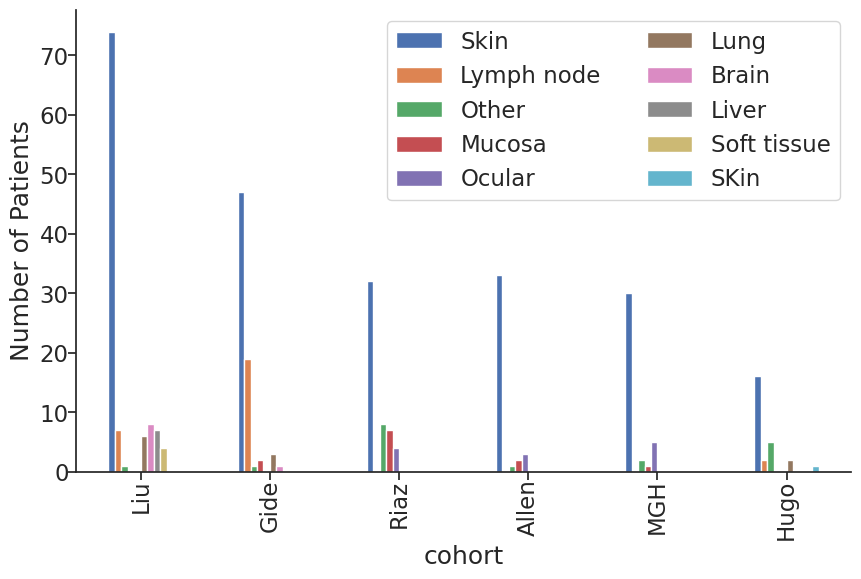

In [80]:
skcm = df_clinical[df_clinical.cancer_type == 'SKCM']
data = skcm.groupby('cohort').apply(lambda x:x.Tissue_map.value_counts()).unstack()
data = data.loc[data.sum(axis=1).sort_values(ascending=False).index]
data = data[data.sum().sort_values(ascending=False).index]
fig, ax = plt.subplots(figsize=(10, 6))
data.plot(kind='bar', ax = ax)
ax.legend(loc='upper right', ncol=2)
ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_ylabel('Number of Patients')

Text(0, 0.5, 'Number of Patients')

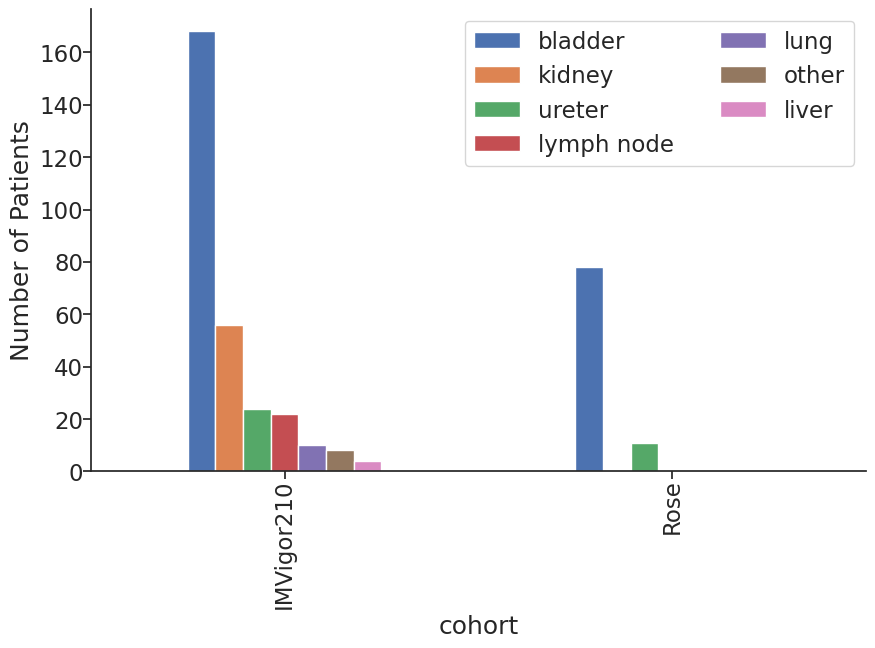

In [81]:
skcm = df_clinical[df_clinical.cancer_type == 'BLCA']
data = skcm.groupby('cohort').apply(lambda x:x.Tissue.value_counts()).unstack()
data = data.loc[data.sum(axis=1).sort_values(ascending=False).index]
data = data[data.sum().sort_values(ascending=False).index]
fig, ax = plt.subplots(figsize=(10, 6))
data.plot(kind='bar', ax = ax)
ax.legend(loc='upper right', ncol=2)
ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_ylabel('Number of Patients')

In [82]:
skcm = df_clinical[df_clinical.cohort == 'IMVigor210']
data = skcm.groupby('cohort').apply(lambda x:x['Immune phenotype'].value_counts())
# data = data.loc[data.sum(axis=1).sort_values(ascending=False).index]
# data = data[data.sum().sort_values(ascending=False).index]
# fig, ax = plt.subplots(figsize=(10, 6))
# data.plot(kind='bar', ax = ax)
# ax.legend(loc='upper right', ncol=2)
# ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
# sns.despine(top=True, right=True, left=False, bottom=False)
# ax.set_ylabel('Number of Patients')

<Axes: xlabel='cohort'>

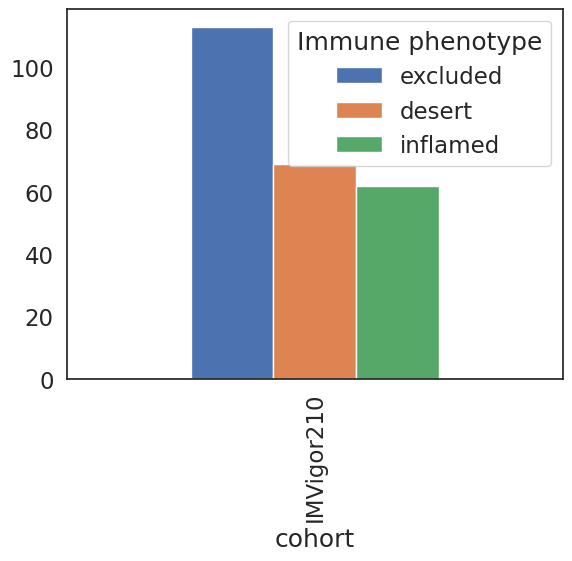

In [83]:
data.plot(kind='bar')